## <center>Online news popularity (CEU-ML 2024)</center>
<center>Viet H. Nguyen</center>

## Introduction
This notebook is part of a Kaggle competition to predict wether online news article is popular. MOre details can be found [here](https://www.kaggle.com/competitions/online-news-popularity-ceu-ml-2024/overview).
In this notebook, I will guide you through all of my modeling experiments and discuss how and why I choose the model for submission!

In [1]:
%%capture
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np

import seaborn as sns
from matplotlib import pyplot as plt

In [2]:
news_df = pd.read_csv('online-news-popularity-ceu-ml-2024/train.csv')
news_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29733 entries, 0 to 29732
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   timedelta                      29733 non-null  int64  
 1   n_tokens_title                 29733 non-null  int64  
 2   n_tokens_content               29733 non-null  int64  
 3   n_unique_tokens                29733 non-null  float64
 4   n_non_stop_words               29733 non-null  float64
 5   n_non_stop_unique_tokens       29733 non-null  float64
 6   num_hrefs                      29733 non-null  int64  
 7   num_self_hrefs                 29733 non-null  int64  
 8   num_imgs                       29733 non-null  int64  
 9   num_videos                     29733 non-null  int64  
 10  average_token_length           29733 non-null  float64
 11  num_keywords                   29733 non-null  int64  
 12  data_channel_is_lifestyle      29733 non-null 

In [3]:
news_df.head(10)

,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,num_videos,...,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,is_popular,article_id
0,594,9,702,0.454545,1.0,0.620438,11,2,1,0,...,1.000000,-0.153395,-0.4,-0.100000,0.000000,0.000000,0.500000,0.000000,0,1
1,346,8,1197,0.470143,1.0,0.666209,21,6,2,13,...,1.000000,-0.308167,-1.0,-0.100000,0.000000,0.000000,0.500000,0.000000,0,3
2,484,9,214,0.618090,1.0,0.748092,5,2,1,0,...,0.433333,-0.141667,-0.2,-0.050000,0.000000,0.000000,0.500000,0.000000,0,5
3,639,8,249,0.621951,1.0,0.664740,16,5,8,0,...,0.500000,-0.500000,-0.8,-0.400000,0.000000,0.000000,0.500000,0.000000,0,6
4,177,12,1219,0.397841,1.0,0.583578,21,1,1,2,...,0.800000,-0.441111,-1.0,-0.050000,0.000000,0.000000,0.500000,0.000000,0,7
5,568,7,126,0.723577,1.0,0.774194,3,3,1,0,...,0.285714,0.000000,0.0,0.000000,0.454545,0.136364,0.045455,0.136364,0,8
6,318,12,1422,0.367994,1.0,0.469256,28,28,26,0,...,0.700000,-0.234167,-0.5,-0.050000,1.000000,0.100000,0.500000,0.100000,0,9
7,582,6,1102,0.451287,1.0,0.642089,7,3,1,0,...,0.800000,-0.151630,-0.4,-0.050000,0.800000,0.400000,0.300000,0.400000,1,11
8,269,9,0,0.000000,0.0,0.000000,0,0,5,0,...,0.000000,0.000000,0.0,0.000000,0.500000,0.500000,0.000000,0.500000,0,12
9,567,7,94,0.755319,1.0,0.812500,8,6,0,11,...,1.000000,-0.183333,-0.2,-0.166667,0.000000,0.000000,0.500000,0.000000,0,14


## Data Cleaning

Upon investigation, there's no data cleaning needed since the dataset has no missing values and the values seem to make sense.

## EDA

Checking the correlation between all the existing variables, I noticed that some of them have very high correlations. To reduce the redundancies, I removed the highly correlated variables before splitting the data into training and test set.

In [4]:
plot_data = news_df.drop(columns=['timedelta', 'is_popular', 'article_id']).corr()
test = plot_data.applymap(lambda x: 1 if x >= 0.8 else -1 if x <= -0.8 else 0)

high_correlation_pairs = []
for row_index, row in test.iterrows():
    for column_name, cell_value in row.items():
        if (cell_value == 1 or cell_value == -1) and row_index != column_name and (row_index + '*' + column_name not in high_correlation_pairs and column_name + '*' + row_index not in high_correlation_pairs):
            high_correlation_pairs.append(row_index + '*' + column_name)
high_correlation_pairs = [(x.split('*')[0], x.split('*')[1]) for x in high_correlation_pairs]
high_correlation_pairs

[('n_unique_tokens', 'n_non_stop_words'),
 ('n_unique_tokens', 'n_non_stop_unique_tokens'),
 ('n_non_stop_words', 'n_non_stop_unique_tokens'),
 ('data_channel_is_world', 'LDA_02'),
 ('kw_min_min', 'kw_max_max'),
 ('kw_max_min', 'kw_avg_min'),
 ('kw_max_avg', 'kw_avg_avg'),
 ('self_reference_min_shares', 'self_reference_avg_sharess'),
 ('self_reference_max_shares', 'self_reference_avg_sharess')]

In [5]:
from sklearn.model_selection import train_test_split

exclude_cols = ['timedelta', 'is_popular', 'article_id', 'kw_min_min', 'kw_max_min', 'kw_max_avg', 'n_non_stop_unique_tokens', 'self_reference_min_shares', 'self_reference_max_shares'] + [col for col in news_df.columns if col.startswith('weekday_is_')] + [col for col in news_df.columns if col.startswith('data_channel_is')]
binary_cols = [col for col in news_df.columns if col.startswith('weekday_is_')] + [col for col in news_df.columns if col.startswith('data_channel_is')] + ['is_weekend']

# split data to train & val & test
outcome = news_df["is_popular"]
features = news_df.drop(columns=exclude_cols)
# features = news_df.drop(columns=['timedelta', 'is_popular', 'article_id'])
prng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.1, random_state=prng)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=prng)
X_val, y_val = X_test, y_test

print(X_train.shape, X_val.shape, X_test.shape)

(26759, 39) (2974, 39) (2974, 39)


## Modeling

### Simple Logit

This simple logit model only use the raw variables that is in the dataset to predict whether the article is popular.

In [6]:
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, roc_auc_score, f1_score

# no regularisation needed so setting the parameter to very high value
Cs_value_logit = [1e20]
scoring='roc_auc'

logit_model = LogisticRegressionCV(
        Cs=Cs_value_logit,
        refit=True, 
        scoring=scoring, 
        solver="liblinear", 
        tol=1e-7, 
        random_state=prng
    )

logit_model.fit(X_train, y_train)

summary_df = pd.DataFrame({'Model': ['Logit as Benchmark'],
                           'Train AUC': [round(roc_auc_score(y_train, logit_model.predict_proba(X_train)[:,1]), 4)],
                           'Val AUC': [round(roc_auc_score(y_val, logit_model.predict_proba(X_val)[:,1]), 4)],
                           'Test AUC': [round(roc_auc_score(y_test, logit_model.predict_proba(X_test)[:,1]), 4)],
                           # 'Train accuracy': [round(accuracy_score(y_train, logit_model.predict(X_train)), 4)],
                           # 'Val accuracy': [round(accuracy_score(y_val, logit_model.predict(X_val)), 4)],
                           # 'Test accuracy': [round(accuracy_score(y_test, logit_model.predict(X_test)), 4)],
                           # 'Train F1 score': [round(f1_score(y_train, logit_model.predict(X_train)), 4)],
                           # 'Val F1 score': [round(f1_score(y_val, logit_model.predict(X_val)), 4)],
                           # 'Test F1 score': [round(f1_score(y_test, logit_model.predict(X_test)), 4)],
                          })
summary_df

,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637


The AUC score for the logit model will be the benchmark for the subsequent models that I experiment with.

In the summary table, there's a column for the validation set AUC score. For non-neural network model, this column is the same as the test AUC score since I will only split once for the training and test set. For the neural network, there is another split of the training set to obtain the validation set.

## Feature Engineering

I also experiment with feature engineering via creating some ratio variables like:
- Keyword density
- Links ratio
- Media ratio
- Sentiment balance
- Emotional intensity

After engineering more features, I test for correlation again among all the variables and remove any that has high correlation. I then split the data again afterward, reseting the reandom seed to obtain the same splits.

In [7]:
def feature_engineer(df):
    # normalized unique tokens and keywords
    # df['e_unique_tokens_normalized'] = df.apply(lambda x: x['n_unique_tokens'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else 0, axis=1)
    # df['e_non_stop_unique_tokens_normalized'] = df.apply(lambda x: x['n_non_stop_unique_tokens'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else 0, axis=1)
    df['e_keyword_density'] = df.apply(lambda x: x['num_keywords'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else x['num_keywords'], axis=1)
    df['e_title_length_ratio'] = df.apply(lambda x: x['n_tokens_title'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else x['n_tokens_title'], axis=1)
    
    # links ratio
    df['e_external_link_ratio'] = df.apply(lambda x: x['num_hrefs'] / x['n_tokens_content'] if x['n_tokens_content'] > 0 else x['num_hrefs'], axis=1)
    df['e_self_reference_link_ratio'] = df.apply(lambda x: x['num_self_hrefs'] / x['num_hrefs'] if x['num_hrefs'] > 0 else x['num_self_hrefs'], axis=1)
    
    # media ratio
    df['e_multimedia_content_ratio'] = df.apply(lambda x: (x['num_imgs'] + x['num_videos']) / x['n_tokens_content'] if x['n_tokens_content'] > 0 else (x['num_imgs'] + x['num_videos']), axis=1)
    
    # composite indicators of sentiment balance or emotional intensity
    df['e_sentiment_balance'] = df['global_rate_positive_words'] - df['global_rate_negative_words']
    df['e_emotional_intensity'] = df['global_sentiment_polarity'] * df['global_subjectivity']
    
    # count of channels associated with each article
    channel_cols = [col for col in news_df.columns if col.startswith('data_channel_is')]
    df['e_num_channels'] = df[channel_cols].sum(axis=1)
    df['e_is_multi_channel'] = df['e_num_channels'].apply(lambda x: 1 if x > 1 else 0)
    
    binary_cols = ['is_weekend', 'e_is_multi_channel']
    
    return df, binary_cols

news_df, binary_cols = feature_engineer(news_df)

In [8]:
plot_data = news_df.drop(columns=['timedelta', 'is_popular', 'article_id']).corr()
test = plot_data.applymap(lambda x: 1 if x >= 0.8 else -1 if x <= -0.8 else 0)

high_correlation_pairs = []
for row_index, row in test.iterrows():
    for column_name, cell_value in row.items():
        if (cell_value == 1 or cell_value == -1) and row_index != column_name and (row_index + '*' + column_name not in high_correlation_pairs and column_name + '*' + row_index not in high_correlation_pairs):
            high_correlation_pairs.append(row_index + '*' + column_name)
high_correlation_pairs = [(x.split('*')[0], x.split('*')[1]) for x in high_correlation_pairs]
high_correlation_pairs

[('n_unique_tokens', 'n_non_stop_words'),
 ('n_unique_tokens', 'n_non_stop_unique_tokens'),
 ('n_non_stop_words', 'n_non_stop_unique_tokens'),
 ('average_token_length', 'e_keyword_density'),
 ('average_token_length', 'e_title_length_ratio'),
 ('data_channel_is_world', 'LDA_02'),
 ('kw_min_min', 'kw_max_max'),
 ('kw_max_min', 'kw_avg_min'),
 ('kw_max_avg', 'kw_avg_avg'),
 ('self_reference_min_shares', 'self_reference_avg_sharess'),
 ('self_reference_max_shares', 'self_reference_avg_sharess'),
 ('global_sentiment_polarity', 'e_emotional_intensity'),
 ('global_rate_positive_words', 'e_sentiment_balance'),
 ('e_keyword_density', 'e_title_length_ratio')]

In [9]:
# exclude_cols_tmp = ['n_non_stop_words','kw_min_min','kw_max_min','kw_max_avg','self_reference_min_shares','self_reference_max_shares','global_sentiment_polarity','global_rate_positive_words','global_rate_negative_words','rate_positive_words','rate_negative_words','max_positive_polarity','min_negative_polarity','abs_title_sentiment_polarity'] + [col for col in news_df.columns if col.startswith('data_channel_is')]
exclude_cols_tmp = ['average_token_length','global_sentiment_polarity','global_rate_negative_words', 'e_title_length_ratio']
[exclude_cols.append(x) for x in exclude_cols_tmp if x not in exclude_cols]
exclude_cols

['timedelta',
 'is_popular',
 'article_id',
 'kw_min_min',
 'kw_max_min',
 'kw_max_avg',
 'n_non_stop_unique_tokens',
 'self_reference_min_shares',
 'self_reference_max_shares',
 'weekday_is_monday',
 'weekday_is_tuesday',
 'weekday_is_wednesday',
 'weekday_is_thursday',
 'weekday_is_friday',
 'weekday_is_saturday',
 'weekday_is_sunday',
 'data_channel_is_lifestyle',
 'data_channel_is_entertainment',
 'data_channel_is_bus',
 'data_channel_is_socmed',
 'data_channel_is_tech',
 'data_channel_is_world',
 'average_token_length',
 'global_sentiment_polarity',
 'global_rate_negative_words',
 'e_title_length_ratio']

In [10]:
# split train, val, test again with engineered features
outcome = news_df["is_popular"]
features = news_df.drop(columns=exclude_cols)
# features = news_df.drop(columns=['timedelta', 'is_popular', 'article_id'])
prng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.1, random_state=prng)
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=prng)
X_val, y_val = X_test, y_test

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

(26759, 44) (2974, 44) (2974, 44) (26759,) (2974,) (2974,)


In [11]:
def update_summary(df, model_name, y_train_true, y_train_pred, y_val_true, y_val_pred, y_test_true, y_test_pred, class1_only=False):
    if class1_only:
        if model_name not in df.Model.values:
            df.loc[len(df.index)] = [model_name, 
                                     '{:.4f}'.format(roc_auc_score(y_train_true, y_train_pred)),
                                     '{:.4f}'.format(roc_auc_score(y_val_true, y_val_pred)),
                                     '{:.4f}'.format(roc_auc_score(y_test_true, y_test_pred)),]
        else:
            df.loc[df.Model == model_name] = [model_name, 
                                             '{:.4f}'.format(roc_auc_score(y_train_true, y_train_pred)),
                                             '{:.4f}'.format(roc_auc_score(y_val_true, y_val_pred)),
                                             '{:.4f}'.format(roc_auc_score(y_test_true, y_test_pred)),]
    else:
        if model_name not in df.Model.values:
            df.loc[len(df.index)] = [model_name, 
                                     '{:.4f}'.format(roc_auc_score(y_train_true, y_train_pred[:,1])),
                                     '{:.4f}'.format(roc_auc_score(y_val_true, y_val_pred[:,1])),
                                     '{:.4f}'.format(roc_auc_score(y_test_true, y_test_pred[:,1])),]
                                     # '{:.4f}'.format(accuracy_score(y_train_true, y_train_pred)),
                                     # '{:.4f}'.format(accuracy_score(y_val_true, y_val_pred)),
                                     # '{:.4f}'.format(accuracy_score(y_test_true, y_test_pred)),
                                     # '{:.4f}'.format(f1_score(y_train_true, y_train_pred)),
                                     # '{:.4f}'.format(f1_score(y_val_true, y_val_pred)),
                                     # '{:.4f}'.format(f1_score(y_test_true, y_test_pred))]
        else:
            df.loc[df.Model == model_name] = [model_name, 
                                             '{:.4f}'.format(roc_auc_score(y_train_true, y_train_pred[:,1])),
                                             '{:.4f}'.format(roc_auc_score(y_val_true, y_val_pred[:,1])),
                                             '{:.4f}'.format(roc_auc_score(y_test_true, y_test_pred[:,1])),]
                                             # '{:.4f}'.format(accuracy_score(y_train_true, y_train_pred)),
                                             # '{:.4f}'.format(accuracy_score(y_val_true, y_val_pred)),
                                             # '{:.4f}'.format(accuracy_score(y_test_true, y_test_pred)),
                                             # '{:.4f}'.format(f1_score(y_train_true, y_train_pred)),
                                             # '{:.4f}'.format(f1_score(y_val_true, y_val_pred)),
                                             # '{:.4f}'.format(f1_score(y_test_true, y_test_pred))]

## Modeling with Feature Engineering

### LASSO Logit

After doing feature engineering, I combine it with a LASSO logit model to regularize the impact by adding more features into the model.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline

lambdas = list(10**np.arange(-1, -3.01, -1/3))
n_obs = len(X_train)
Cs_values = [1/(l*n_obs) for l in lambdas]

lasso_search = LogisticRegressionCV(
    Cs = Cs_values, 
    penalty = 'l1', # L1 makes it lasso
    cv = 5, 
    refit = True, 
    scoring = scoring, 
    solver = 'liblinear',
    random_state = prng,
    # verbose=True
)

preprocessor = ColumnTransformer(
    transformers=[
        ('scale', StandardScaler(), features.drop(columns=binary_cols).columns),
        ('leave_out', 'passthrough', binary_cols)  # Leave out columns without transformation
    ],
    remainder='passthrough'  # Drop columns not specified in transformers
)

lasso_model = Pipeline(
     [('preprocessor', preprocessor),
     ("regressor", lasso_search)
     ], verbose=True
)

lasso_model.fit(X_train, y_train)

update_summary(summary_df, 
               'LASSO Logit', 
               y_train, 
               lasso_model.predict_proba(X_train),
               y_val, 
               lasso_model.predict_proba(X_val), 
               y_test, 
               lasso_model.predict_proba(X_test))
summary_df

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   0.0s
[Pipeline] ......... (step 2 of 2) Processing regressor, total=   3.9s


,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791


From the summary table, the LASSO logit's AUC score in both the training and test set improves compared to the benchmark. This gives me some confidence that the feature engineering does provide more information for the model to capture the data better.

### Random Forest

I experiment with ensemble methods starting with a random forest model. In the code, there are some optimizations that I have done to optimize this model:
- Cross validation to obtain the best hyperparameters (the hyperparameters grid is commented out and replaced with the best parameters to cut down on the rerun time)
- Perform permutation importance analysis to find the most impactful predictors
- Refit the model after removing unimportant predictors from the available variables 

In [13]:
rf_high_perm = ['kw_avg_avg',
 'self_reference_avg_sharess',
 'kw_min_avg',
 'LDA_03',
 'e_multimedia_content_ratio',
 'e_num_channels',
 'num_hrefs',
 'num_imgs',
 'LDA_04',
 'kw_min_max',
 'LDA_02',
 'e_self_reference_link_ratio',
 'n_unique_tokens',
 'num_videos',
 'global_subjectivity',
 'n_tokens_title',
 'e_external_link_ratio',
 'n_tokens_content',
 'avg_negative_polarity',
 'title_sentiment_polarity',
 'e_sentiment_balance',
 'abs_title_sentiment_polarity',
 'e_emotional_intensity',
 'global_rate_positive_words',
 'is_weekend',
 'kw_max_max',
 'kw_avg_max',
 'num_self_hrefs',
 'title_subjectivity',
 'rate_positive_words',
 'rate_negative_words',
 'max_negative_polarity']

In [14]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

# max_depth = [int(x) for x in np.linspace(1, 100, num = 4)]
max_depth = [15, 18, 20, 25]
max_depth.append(None)

# grid = {'max_features': [0.3, 0.5, 1],
#         'criterion':['gini'],
#         'max_depth': max_depth,
#         'min_samples_split': [5, 10, 15],
#         "min_samples_leaf": [2, 4, 8]
#         }

# grid =  {'criterion': ['gini'],
#  'max_depth': [50],
#  'max_features': [1],
#  'min_samples_leaf': [4],
#  'min_samples_split': [10]}

grid = {'criterion': ['gini'],
         'max_depth': [15],
         'max_features': [0.3],
         'min_samples_leaf': [8],
         'min_samples_split': [5]}

prob_forest_search = GridSearchCV(
    RandomForestClassifier(random_state = prng, oob_score=True, n_estimators=500, bootstrap=True), 
    grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc'], 
    verbose=True,
    # random_state=prng,
    n_jobs=-1)

rf_model = Pipeline(
    [("rf", prob_forest_search)
     ], verbose=True
)

rf_model.fit(X_train[rf_high_perm], y_train)
predictions_rf = rf_model.predict(X_val[rf_high_perm])
accuracy_score(y_val, predictions_rf)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ................ (step 1 of 1) Processing rf, total= 2.0min


0.8910558170813719

In [15]:
prob_forest_search.best_params_

{'criterion': 'gini',
 'max_depth': 15,
 'max_features': 0.3,
 'min_samples_leaf': 8,
 'min_samples_split': 5}

In [16]:
update_summary(summary_df, 
               'Random Forest CV', 
               y_train, 
               rf_model.predict_proba(X_train[rf_high_perm]),
               y_val, 
               rf_model.predict_proba(X_val[rf_high_perm]), 
               y_test, 
               rf_model.predict_proba(X_test[rf_high_perm]))
summary_df

,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086


There is a significant jump in the AUC score using the optimized random forest model by almost 3%. It seems that the ensemble method is better at fitting the data and capture more patterns compared to the other models, possibly because the random forest is able to pick up the non-linear and interaction relationship among the predictors.

In [17]:
# from sklearn.inspection import permutation_importance
# 
# rf_imp = permutation_importance(
#     rf_model,
#     X_test[rf_high_perm],
#     y_test,
#     n_repeats=10,
#     random_state=prng,
#     # scoring="neg_root_mean_squared_error"
# )
# 
# grouped_var_imp = (pd.DataFrame(
#         rf_imp.importances_mean,
#         features.columns)
#                       .sort_values(by = 0, ascending = False)
#                       .reset_index()
#                       .rename(columns={'index': 'variable', 0: 'imp'}))
# grouped_var_imp['cumulative_imp'] = grouped_var_imp.imp.cumsum()
# 
# rf_fig = sns.barplot(
#     data = grouped_var_imp,
#     x="imp", y="variable")
# rf_fig.set(title='Random forest model grouped feature importances', xlabel="importance", ylabel="variable")
# plt.show()

In [18]:
# grouped_var_imp[(grouped_var_imp['imp'] >= 0.0001)]['variable'].tolist()

### GBM

I also experiment with the gradient boosting model (specifically a variant of it using sklearn HistGradientBoostingClassifier as it runs faster than the traditional GradientBoostingClassifier). I also run the optimization similarly to that of the random forest model. Again, the tuning grid is raplaced by the optimized grid for re-running purpose.

In [19]:
gbm_high_perm = ['kw_avg_avg',
 'self_reference_avg_sharess',
 'kw_min_avg',
 'e_self_reference_link_ratio',
 'kw_min_max',
 'kw_avg_max',
 'num_videos',
 'LDA_02',
 'num_imgs',
 'num_hrefs',
 'e_num_channels',
 'LDA_04',
 'n_tokens_content',
 'is_weekend',
 'global_subjectivity',
 'num_self_hrefs',
 'n_non_stop_words',
 'kw_max_max',
 'n_tokens_title',
 'title_subjectivity',
 'e_emotional_intensity',
 'e_multimedia_content_ratio',
 'abs_title_subjectivity',
 'kw_avg_min',
 'abs_title_sentiment_polarity',
 'LDA_03',
 'title_sentiment_polarity',
 'avg_negative_polarity',
 'e_external_link_ratio',
 'e_sentiment_balance',
 'max_positive_polarity',
 'LDA_01']

In [20]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import HistGradientBoostingClassifier

# max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth = [15, 18, 20, 25]
max_depth.append(None)

# gbm_grid = {'max_features': [0.1, 0.15],
#         'max_depth': max_depth,
#         "min_samples_leaf": [15, 18, 20],
#         'l2_regularization': [0.05, 0.08, 0.1],
#         'class_weight': [None],
#         'max_iter': [500],
#         'learning_rate': [0.01, 0.001]
#         }

gbm_grid =  {'class_weight': [None],
         'l2_regularization': [0.05],
         'learning_rate': [0.01],
         'max_depth': [20],
         'max_features': [0.1],
         'max_iter': [500],
         'min_samples_leaf': [15]}

gbm_search = GridSearchCV(
    HistGradientBoostingClassifier(random_state = prng), 
    gbm_grid, 
    cv=5, 
    refit='roc_auc',
    scoring = ['roc_auc'], 
    verbose=True,
    # random_state=prng,
    n_jobs=-1)

# RF as benchmark
gbm_model = Pipeline(
    [("gbm", gbm_search)
     ], verbose=True
)

gbm_model.fit(X_train[gbm_high_perm], y_train)
predictions_gbm = gbm_model.predict(X_val[gbm_high_perm])
accuracy_score(y_val, predictions_gbm)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[Pipeline] ............... (step 1 of 1) Processing gbm, total=  12.6s


0.8910558170813719

In [21]:
gbm_search.best_params_

{'class_weight': None,
 'l2_regularization': 0.05,
 'learning_rate': 0.01,
 'max_depth': 20,
 'max_features': 0.1,
 'max_iter': 500,
 'min_samples_leaf': 15}

In [22]:
update_summary(summary_df, 
               'GBM CV', 
               y_train, 
               gbm_model.predict_proba(X_train[gbm_high_perm]),
               y_val, 
               gbm_model.predict_proba(X_val[gbm_high_perm]), 
               y_test, 
               gbm_model.predict_proba(X_test[gbm_high_perm]))
summary_df

,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086
3,GBM CV,0.8193,0.7133,0.7133


From the summary table, the gradient boosting is the best model so far in terms of the AUC score for the unseen data. The lower AUC score in the training set compared to the random forest suggest that there might be some training overfitting happen with the random forest. The prediction submission on Kaggle also confirms this hypothesis as the score for the gradient boosting model is the highest. 

In [23]:
# from sklearn.inspection import permutation_importance
# 
# gbm_imp = permutation_importance(
#     gbm_model,
#     X_test,
#     y_test,
#     n_repeats=10,
#     random_state=prng,
#     # scoring="neg_root_mean_squared_error"
# )
# 
# grouped_var_imp = (pd.DataFrame(
#         gbm_imp.importances_mean,
#         features.columns)
#                       .sort_values(by = 0, ascending = False)
#                       .reset_index()
#                       .rename(columns={'index': 'variable', 0: 'imp'}))
# grouped_var_imp['cumulative_imp'] = grouped_var_imp.imp.cumsum()
# 
# gbm_fig = sns.barplot(
#     data = grouped_var_imp,
#     x="imp", y="variable")
# gbm_fig.set(title='GBM model grouped feature importances', xlabel="importance", ylabel="variable")
# plt.show()

In [24]:
# grouped_var_imp[(grouped_var_imp['imp'] >= 0.0001)]['variable'].tolist();

In [25]:
# save original X, y data
X_ori_sets = [X_train.copy(), X_val.copy(), X_test.copy()]
y_ori_sets = [y_train.copy(), y_val.copy(), y_test.copy()]

print(X_ori_sets[0].shape, X_ori_sets[1].shape, X_ori_sets[2].shape, y_ori_sets[0].shape, y_ori_sets[1].shape, y_ori_sets[2].shape)

(26759, 44) (2974, 44) (2974, 44) (26759,) (2974,) (2974,)


### NN with Sigmoid activation

Starting from here, all the subsequent models are neural network or include the neural network as part of the model. To train these models, I split the training set to obtain the validation set with the 9:1 ratio. 

The first neural network model consists of 1 hidden layer and an output layer with 1 neuron and use the sigmoid function as activation. The output thus can be directly interpreted as the probability for whether an article is popular.

I have been optimizing the network to obtain the best AUC score by:
- Increase the number of layers
- Increase the number of neurons
- Try different mini batch size
- Introduce the kernel_regularizer with L1 regularization with different strength
- Add dropout layer with different ratios
- Introduce the kernel_initializer to pre-set the weight for different layers
- Try different learning rates
- Customize the loss function to heavily penalize false negative (FN) predictions

I also think about convolution layers but since this is structured tabular data, there's no real relevant connection to the surrounding data points like in unstructured data. Hence, applying convolution results in less accurate data to train with.

Subsequent neural network models will also undergo the same optimizations as above to obtain the best AUC score.

In [26]:
# split train, val, test again with engineered features
outcome = news_df["is_popular"]
# features = news_df[high_performance_predictors]
features = news_df.drop(columns=exclude_cols)
# features = news_df.drop(columns=['timedelta', 'is_popular', 'article_id'])
prng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.1, random_state=prng)
# X_val, y_val = X_test, y_test
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=prng)


print(X_train.shape, X_val.shape, X_test.shape)

(24083, 44) (2676, 44) (2974, 44)


In [27]:
from sklearn.preprocessing import MinMaxScaler

# normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
# scaler.fit(features)
columns_not_to_scale = [col for col in X_train.columns if col not in binary_cols]
scaler.fit(X_train[columns_not_to_scale])

X_train[columns_not_to_scale] = scaler.transform(X_train[columns_not_to_scale])
X_val[columns_not_to_scale] = scaler.transform(X_val[columns_not_to_scale])
X_test[columns_not_to_scale] = scaler.transform(X_test[columns_not_to_scale])

In [28]:
def plot_history(fit_history):
    train_auc_col = [col for col in fit_history.keys() if col.startswith('auc')][0]
    val_auc_col = [col for col in fit_history.keys() if col.startswith('val_auc')][0]
    plt.plot(fit_history[train_auc_col], label='Training AUC')
    plt.plot(fit_history[val_auc_col], label='Validation AUC')
    plt.xlabel('Epoch')
    plt.ylabel('AUC Score')
    plt.title('Training and Validation AUC score')
    plt.legend()
    plt.show()

In [29]:
y_train_sigmoid, y_val_sigmoid, y_test_sigmoid = y_train, y_val, y_test

In [30]:
import tensorflow as tf

def custom_loss(y_true, y_pred):
    # Define weights
    false_positive_weight = 1.0
    false_negative_weight = 10000.0

    # Calculate binary cross entropy
    bce = tf.keras.losses.BinaryCrossentropy()

    # Calculate loss
    loss = bce(y_true, y_pred)

    # Calculate weighted loss
    weighted_loss = tf.where(tf.greater(y_true, y_pred), false_negative_weight * loss, false_positive_weight * loss)

    return tf.reduce_mean(weighted_loss)

Epoch 1/200
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 6s 712us/step - accuracy: 0.7593 - auc: 0.5217 - f1_score: 0.2174 - loss: 1227.2429 - val_accuracy: 0.8610 - val_auc: 0.5912 - val_f1_score: 0.2231 - val_loss: 1187.1758
Epoch 2/200
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 5s 645us/step - accuracy: 0.7919 - auc: 0.5843 - f1_score: 0.2174 - loss: 1151.6146 - val_accuracy: 0.8333 - val_auc: 0.6152 - val_f1_score: 0.2231 - val_loss: 1143.6550
Epoch 3/200
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 5s 618us/step - accuracy: 0.7922 - auc: 0.6138 - f1_score: 0.2174 - loss: 1114.5966 - val_accuracy: 0.8188 - val_auc: 0.6238 - val_f1_score: 0.2231 - val_loss: 1115.6023
Epoch 4/200
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 5s 617us/step - accuracy: 0.7836 - auc: 0.6218 - f1_score: 0.2174 - loss: 1084.9539 - val_accuracy: 0.8079 - val_auc: 0.6269 - val_f1_score: 0.2231 - val_loss: 1094.1700
Epoch 5/200
8028/8028 ━━━━━━━━━━━━━━━━━━━━ 5s 665us/step - accuracy: 0.7831 - auc: 0.6221 - f1_score: 0.2174 - loss: 1068.6283 - val_accuracy: 0.804

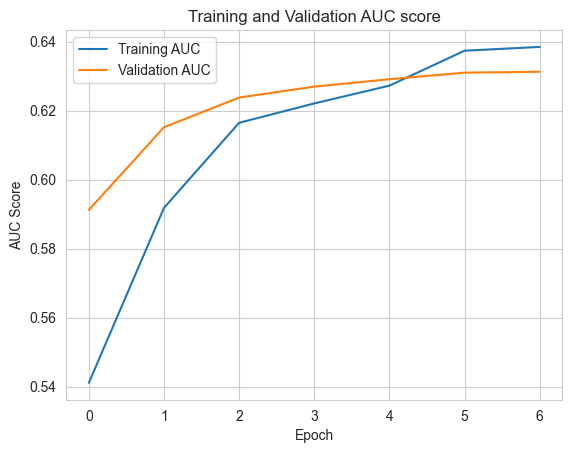

In [31]:
from keras.metrics import AUC, F1Score
from keras.models import Sequential
from keras.layers import Input, Dense, Normalization, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1
import keras

# Build the simple fully connected single hidden layer network model
# simple_model = Sequential([
#     Input(shape=X_train.shape[1:]),
#     Dense(22, activation='relu', kernel_regularizer=l1(0.5)), 
#     Dropout(0.7),
#     Dense(1, activation='sigmoid', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal')
# ])
simple_model = Sequential([
    Input(shape=X_train.shape[1:]),
    # Normalization(axis=-1),
    Dense(256, activation='relu', kernel_regularizer=l1(0.5)),   
    Dropout(0.4),
    Dense(1, activation='sigmoid', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal')
])

# Compile the model
opt = Adam(learning_rate=0.00001)
simple_model.compile(loss=custom_loss, optimizer=opt, metrics=[AUC(), 'accuracy', F1Score()])
# print(simple_model.summary())

# Fit the model
keras.utils.set_random_seed(42)  # for reproducibility
# simple_history = simple_model.fit(X_train, y_train_sigmoid, validation_data=(X_val, y_val_sigmoid), epochs=500, batch_size=256, callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=3, verbose=1, min_delta=0.01)], verbose=True)
simple_history = simple_model.fit(X_train, y_train_sigmoid, validation_data=(X_val, y_val_sigmoid), epochs=200, batch_size=3, callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=3, verbose=1, min_delta=0.01)], verbose=True)

plot_history(simple_history.history)

In [32]:
update_summary(summary_df, 
               'Sigmoid NN', 
               y_train_sigmoid,
               simple_model.predict(X_train), 
               y_val_sigmoid,
               simple_model.predict(X_val), 
               y_test_sigmoid,
               simple_model.predict(X_test),
               class1_only=True)
summary_df

753/753 ━━━━━━━━━━━━━━━━━━━━ 0s 361us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 316us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 337us/step


,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086
3,GBM CV,0.8193,0.7133,0.7133
4,Sigmoid NN,0.6578,0.6321,0.6611


The sigmoid neural network performs worse compared to the ensemble models even with all the trial and errors with optimizations. Interestingly, the more layers or neurons added, the worse the performance becomes. Although I do not have good explanation for this behavior, it seems likely that the neural network is not fit for structured data compared to ensemble models. There are also possible improvements for label engineering or other network type/configuration. However, with the dataset, I have already exhausted possible enegineering option that can be done. Hence, moving forward in the notebook, I will experiment with other network configurations.

## NN with Softmax activation

This network is similar to the network using sigmoid activation functions, with the exception in the output layer: instead of a single neuron using sigmoid function, it uses a 2-neuron layer with a softmax activiation function. The network is also optimized with all the options like the sigmoid neural network.

In [33]:
from keras.utils import to_categorical

print(f"Dimension of y: {y_train.shape}")

# Convert target variables to categorical
num_classes = 2
y_sets = [y_train, y_val, y_test]
y_train, y_val, y_test = [to_categorical(y, num_classes=num_classes) for y in y_sets]
print(f"Dimension of y: {y_train.shape}")

Dimension of y: (24083,)
Dimension of y: (24083, 2)


In [34]:
def custom_categorical_loss(y_true, y_pred):
    # Define class weights
    class_weights = tf.constant([1.0, 1000.0])  # Assuming there are 2 classes with different weights

    # Calculate Categorical Crossentropy
    cat_crossentropy = tf.keras.losses.CategoricalCrossentropy(from_logits=False)

    # Calculate raw loss
    raw_loss = cat_crossentropy(y_true, y_pred)

    # Apply class weights
    weighted_loss = raw_loss * class_weights

    # Reduce along the class axis
    weighted_loss = tf.reduce_mean(weighted_loss, axis=-1)

    return weighted_loss

Epoch 1/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7979 - auc_1: 0.8498 - f1_score: 0.5033 - loss: 362.8992 - val_accuracy: 0.8744 - val_auc_1: 0.8720 - val_f1_score: 0.4665 - val_loss: 278.6981
Epoch 2/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 711us/step - accuracy: 0.8102 - auc_1: 0.8540 - f1_score: 0.5027 - loss: 356.7601 - val_accuracy: 0.8744 - val_auc_1: 0.8721 - val_f1_score: 0.4665 - val_loss: 277.3033
Epoch 3/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 686us/step - accuracy: 0.8213 - auc_1: 0.8601 - f1_score: 0.5021 - loss: 346.4251 - val_accuracy: 0.8744 - val_auc_1: 0.8721 - val_f1_score: 0.4665 - val_loss: 275.6946
Epoch 4/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 699us/step - accuracy: 0.8281 - auc_1: 0.8627 - f1_score: 0.5004 - loss: 339.9158 - val_accuracy: 0.8744 - val_auc_1: 0.8728 - val_f1_score: 0.4665 - val_loss: 274.0124
Epoch 5/300
377/377 ━━━━━━━━━━━━━━━━━━━━ 0s 657us/step - accuracy: 0.8379 - auc_1: 0.8674 - f1_score: 0.5025 - loss: 330.7993 - val_accuracy: 0.8744 -

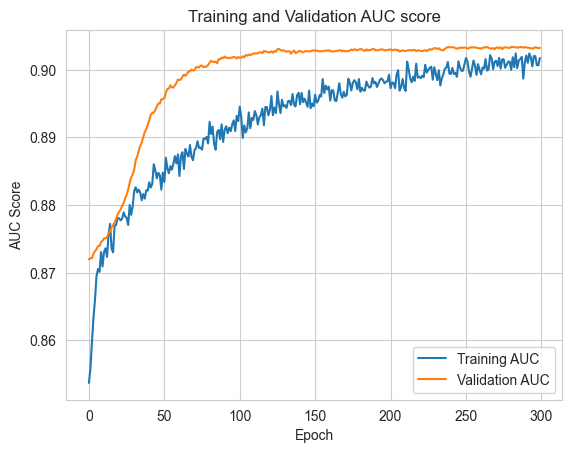

In [35]:
from keras.models import Sequential
from keras.layers import Input, Dense
import keras

# Build the simple fully connected single hidden layer network model
simple_softmax_model = Sequential([
    Input(shape=X_train.shape[1:]), 
    # Dropout(0.4), 
    # Normalization(),
    # Dense(16384, activation='relu', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal'), 
    Dense(22, activation='relu', kernel_regularizer=l1(0.5)), 
    Dropout(0.7),
    Dense(2, activation='softmax', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal')
])

# Compile the model
opt = Adam(learning_rate=0.00001)
simple_softmax_model.compile(loss=custom_categorical_loss, optimizer=opt, metrics=[AUC(), 'accuracy', F1Score()])
# print(simple_model.summary())

# Fit the model
keras.utils.set_random_seed(42)  # for reproducibility
simple_softmax_history = simple_softmax_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=300, callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=3, verbose=1, min_delta=0.01)], batch_size=64)
# simple_softmax_history = simple_softmax_model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=300, callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, verbose=1)], batch_size=128)

# Evaluation of the model on the validation set
scores = simple_softmax_model.evaluate(X_val, y_val)
# scores = simple_softmax_model.evaluate(X_test, y_test)

plot_history(simple_softmax_history.history)

In [36]:
# update_summary_score(summary_df, 
#                'Softmax NN', 
#                simple_softmax_model.evaluate(X_train, y_train)[2], 
#                scores[2], 
#                simple_softmax_model.evaluate(X_test, y_test)[2])
               # simple_softmax_model.evaluate(X_train, y_train)[1], 
               # scores[1], 
               # simple_softmax_model.evaluate(X_test, y_test)[1],
               # simple_softmax_model.evaluate(X_train, y_train)[3].numpy()[1], 
               # scores[3].numpy()[1], 
               # simple_softmax_model.evaluate(X_test, y_test)[3].numpy()[1])
update_summary(summary_df, 
               'Softmax NN', 
               y_train_sigmoid,
               simple_softmax_model.predict(X_train), 
               y_val_sigmoid,
               simple_softmax_model.predict(X_val), 
               y_test_sigmoid,
               simple_softmax_model.predict(X_test))
summary_df

753/753 ━━━━━━━━━━━━━━━━━━━━ 0s 371us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 321us/step


,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086
3,GBM CV,0.8193,0.7133,0.7133
4,Sigmoid NN,0.6578,0.6321,0.6611
5,Softmax NN,0.6555,0.6314,0.6611


The softmax neural network performs comparable to the sigmoid neural network in predicting for popularity with the test set. However, the performance on the validation set is worse, which raise some concern how it performs on a different unseen dataset.

### Neural network with SMOTE

I also experiment with oversampling since the poplar articles are rarer than the non-popular ones. The hypothesis is the model might nto be able to capture the patterns of the rare cases, hence oversampling the positive cases might help. This neural network share the same configuration with the sigmoid neural network and undergo the same optimizations, except for the adjustment in the oversampling strategy.

In [37]:
from imblearn.over_sampling import SMOTE, RandomOverSampler

smt = RandomOverSampler(sampling_strategy=0.5, random_state=prng)
X_smote, y_smote = smt.fit_resample(X_train, y_train_sigmoid)
# y_smote = to_categorical(y_smote, num_classes=num_classes)

In [38]:
def custom_loss_smote(y_true, y_pred):
    # Define weights
    false_positive_weight = 1.0
    false_negative_weight = 10000.0

    # Calculate binary cross entropy
    bce = tf.keras.losses.BinaryCrossentropy()

    # Calculate loss
    loss = bce(y_true, y_pred)

    # Calculate weighted loss
    weighted_loss = tf.where(tf.greater(y_true, y_pred), false_negative_weight * loss, false_positive_weight * loss)

    return tf.reduce_mean(weighted_loss)

Epoch 1/200
991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 894us/step - accuracy: 0.6478 - auc_3: 0.5224 - f1_score: 0.4939 - loss: 2565.2551 - val_accuracy: 0.8726 - val_auc_3: 0.6188 - val_f1_score: 0.2231 - val_loss: 1042.6143
Epoch 2/200
991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 829us/step - accuracy: 0.6739 - auc_3: 0.5809 - f1_score: 0.4939 - loss: 2490.7603 - val_accuracy: 0.8636 - val_auc_3: 0.6284 - val_f1_score: 0.2231 - val_loss: 1028.4751
Epoch 3/200
991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 742us/step - accuracy: 0.6728 - auc_3: 0.6013 - f1_score: 0.4939 - loss: 2462.0571 - val_accuracy: 0.8498 - val_auc_3: 0.6335 - val_f1_score: 0.2231 - val_loss: 1014.7947
Epoch 4/200
991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 680us/step - accuracy: 0.6708 - auc_3: 0.6183 - f1_score: 0.4939 - loss: 2435.5093 - val_accuracy: 0.8363 - val_auc_3: 0.6353 - val_f1_score: 0.2231 - val_loss: 1002.3637
Epoch 5/200
991/991 ━━━━━━━━━━━━━━━━━━━━ 1s 702us/step - accuracy: 0.6752 - auc_3: 0.6237 - f1_score: 0.4939 - loss: 2418.4424 - val_accurac

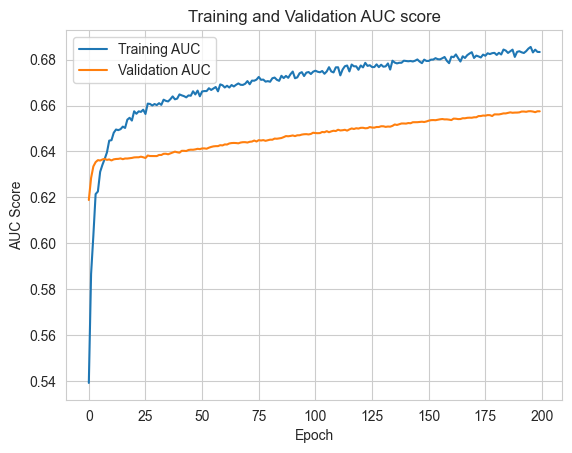

In [40]:
from sklearn.utils import compute_class_weight

# Build the simple fully connected single hidden layer network model
# smote_model = Sequential([
#     Input(shape=X_train.shape[1:]),
#     # Dense(22, activation='relu', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal'),   
#     # Dropout(0.4),
#     Dense(22, activation='relu', kernel_regularizer=l1(0.5)), 
#     Dropout(0.7),
#     # Dense(1, activation='sigmoid', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal')
#     Dense(1, activation='sigmoid', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal')
# ])
smote_model = Sequential([
    Input(shape=X_train.shape[1:]),
    # Normalization(axis=-1),
    Dense(256, activation='relu', kernel_regularizer=l1(0.5)),   
    Dropout(0.4),
    Dense(1, activation='sigmoid', kernel_regularizer=l1(0.5), kernel_initializer='glorot_normal')
])

# Compile the model
opt = Adam(learning_rate=0.00001)
smote_model.compile(loss=custom_loss_smote, optimizer=opt, metrics=[AUC(), 'accuracy', F1Score()])

# Fit the model
keras.utils.set_random_seed(42)  # for reproducibility
# smote_history = smote_model.fit(X_smote, y_smote, validation_data=(X_val, y_val_sigmoid), epochs=500, batch_size=256, callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=3, verbose=1, min_delta=0.01)], verbose=True)
smote_history = smote_model.fit(X_smote, y_smote, validation_data=(X_val, y_val_sigmoid), epochs=200, batch_size=32, callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=3, verbose=1, min_delta=0.01)], verbose=True)

plot_history(smote_history.history)

In [41]:
update_summary(summary_df, 
               'SMOTE NN', 
               y_train_sigmoid,
               smote_model.predict(X_train), 
               y_val_sigmoid,
               smote_model.predict(X_val), 
               y_test_sigmoid,
               smote_model.predict(X_test),
               class1_only=True)
summary_df

753/753 ━━━━━━━━━━━━━━━━━━━━ 0s 329us/step
84/84 ━━━━━━━━━━━━━━━━━━━━ 0s 301us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step


,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086
3,GBM CV,0.8193,0.7133,0.7133
4,Sigmoid NN,0.6578,0.6321,0.6611
5,Softmax NN,0.6555,0.6314,0.6611
6,SMOTE NN,0.6879,0.6579,0.6740


Surprisingly, with oversampling, the neural network performs much better. This result gives confidence that the model capture the patterns of popular articles better via oversampling.

## Stacked Model

This model is a neural network similar to the sigmoid neural network, with a twist that it includes the predictions of the gradient boosting model as an input. The idea is to take advantages of the gradient boosting great performance to improve the neural network performance.

In [42]:
# split train, val, test again with engineered features
outcome = news_df["is_popular"]
# features = news_df[high_performance_predictors]
features = news_df.drop(columns=exclude_cols)
# features = news_df.drop(columns=['timedelta', 'is_popular', 'article_id'])
prng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.1, random_state=prng)
X_val, y_val = X_test, y_test
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=prng)
X_train_no_scale, X_val_no_scale, X_test_no_scale = X_train.copy()[gbm_high_perm], X_val.copy()[gbm_high_perm], X_test.copy()[gbm_high_perm]

# normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
# scaler.fit(features)
columns_not_to_scale = [col for col in X_train.columns if col not in binary_cols]
scaler.fit(X_train[columns_not_to_scale])

X_train[columns_not_to_scale] = scaler.transform(X_train[columns_not_to_scale])
X_val[columns_not_to_scale] = scaler.transform(X_val[columns_not_to_scale])
X_test[columns_not_to_scale] = scaler.transform(X_test[columns_not_to_scale])

gbm_pred_train, gbm_pred_val, gbm_pred_test = gbm_model.predict_proba(X_train_no_scale), gbm_model.predict_proba(X_val_no_scale), gbm_model.predict_proba(X_test_no_scale)

X_train = np.hstack((X_train, gbm_pred_train))
X_val = np.hstack((X_val, gbm_pred_val))
X_test = np.hstack((X_test, gbm_pred_test))
# X_train = np.hstack((X_train, gbm_pred_train[:,1].reshape(-1, 1)))
# X_val = np.hstack((X_val, gbm_pred_val[:,1].reshape(-1, 1)))
# X_test = np.hstack((X_test, gbm_pred_test[:,1].reshape(-1, 1)))

Epoch 1/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.7849 - auc_4: 0.5201 - f1_score: 0.2223 - loss: 1157.2595 - val_accuracy: 0.8911 - val_auc_4: 0.5272 - val_f1_score: 0.1965 - val_loss: 856.8764
Epoch 2/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 746us/step - accuracy: 0.8750 - auc_4: 0.5539 - f1_score: 0.2223 - loss: 954.2651 - val_accuracy: 0.8911 - val_auc_4: 0.5547 - val_f1_score: 0.1965 - val_loss: 942.5197
Epoch 3/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.8750 - auc_4: 0.5749 - f1_score: 0.2223 - loss: 911.5139 - val_accuracy: 0.8911 - val_auc_4: 0.5690 - val_f1_score: 0.1965 - val_loss: 977.7761
Epoch 4/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 750us/step - accuracy: 0.8750 - auc_4: 0.5908 - f1_score: 0.2223 - loss: 896.9622 - val_accuracy: 0.8911 - val_auc_4: 0.5842 - val_f1_score: 0.1965 - val_loss: 980.3577
Epoch 5/200
419/419 ━━━━━━━━━━━━━━━━━━━━ 0s 720us/step - accuracy: 0.8750 - auc_4: 0.6038 - f1_score: 0.2223 - loss: 885.4709 - val_accuracy: 0.8911 

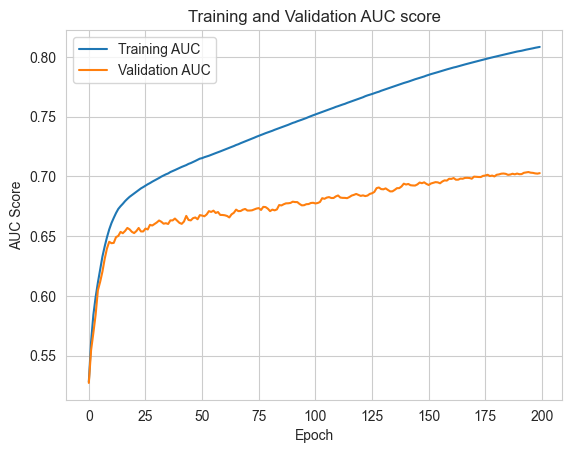

In [43]:
from keras.metrics import AUC, F1Score
from keras.models import Sequential
from keras.layers import Input, Dense, Normalization, Dropout, BatchNormalization
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.regularizers import l1
import keras

l1_reg = 0.5

# Build the simple fully connected single hidden layer network model
stacked_model = Sequential([
    Input(shape=X_train.shape[1:]),
    # Normalization(axis=-1),
    # Dense(256, activation='relu', kernel_regularizer=l1(0.5)),   
    Dense(256, activation='relu', kernel_regularizer=l1(l1_reg)),   
    # Dropout(0.4),
    Dense(1, activation='sigmoid', kernel_regularizer=l1(l1_reg))
])

# Compile the model
opt = Adam(learning_rate=0.00001)
stacked_model.compile(loss=custom_loss, optimizer=opt, metrics=[AUC(), 'accuracy', F1Score()])

# Fit the model
keras.utils.set_random_seed(42)  # for reproducibility
stacked_history = stacked_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=200, batch_size=64, callbacks=[EarlyStopping(monitor='val_auc', mode='max', patience=3, verbose=1, min_delta=0.01)], verbose=True)

plot_history(stacked_history.history)

In [44]:
update_summary(summary_df, 
               'Stacked NN', 
               y_train,
               stacked_model.predict(X_train), 
               y_val,
               stacked_model.predict(X_val), 
               y_test,
               stacked_model.predict(X_test),
               class1_only=True)
summary_df

837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 320us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 283us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step


,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086
3,GBM CV,0.8193,0.7133,0.7133
4,Sigmoid NN,0.6578,0.6321,0.6611
5,Softmax NN,0.6555,0.6314,0.6611
6,SMOTE NN,0.6879,0.6579,0.6740
7,Stacked NN,0.8086,0.7031,0.7031


Fortunately, it seems like the combination works. The stacked model improves upon the other networks quite significantly. However, its performance is still worse than the normal gradient boosting model.

## Hybrid Model

This model is also a combination of the gradient boosting model and the oversampling with smote using sigmoid activation neural network. The configuration here is a bit more intricate. The main model itself is actually a logit model, but the predictions from the gradient boosting and sigmoid neural network are used as input. The logit model is cross validated to get the best regularization parameter.

In [45]:
# split train, val, test again with engineered features
outcome = news_df["is_popular"]
# features = news_df[high_performance_predictors]
features = news_df.drop(columns=exclude_cols)
# features = news_df.drop(columns=['timedelta', 'is_popular', 'article_id'])
prng = np.random.RandomState(42)
X_train, X_test, y_train, y_test = train_test_split(features, outcome, test_size=0.1, random_state=prng)
X_val, y_val = X_test, y_test
# X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=prng)

# normalize data
scaler = MinMaxScaler(feature_range=(-1, 1))
# scaler = StandardScaler()
# scaler.fit(features)
columns_not_to_scale = [col for col in X_train.columns if col not in binary_cols]
scaler.fit(X_train[columns_not_to_scale])

X_train[columns_not_to_scale] = scaler.transform(X_train[columns_not_to_scale])
X_val[columns_not_to_scale] = scaler.transform(X_val[columns_not_to_scale])
X_test[columns_not_to_scale] = scaler.transform(X_test[columns_not_to_scale])

In [46]:
def get_hybrid_data(ml_model, dl_model, ml_data, dl_data):
    ml_pred = ml_model.predict_proba(ml_data)
    dl_pred = dl_model.predict(dl_data)
    if dl_model.layers[-1].units == 1:
        df = pd.DataFrame({
            'ml_model_0': ml_pred[:,0],
            'ml_model_1': ml_pred[:,1],
            'dl_model': dl_pred.flatten()
        })
    else:
        df = pd.DataFrame({
            'ml_model_0': ml_pred[:,0],
            'ml_model_1': ml_pred[:,1],
            'dl_model_0': dl_pred[:,0],
            'dl_model_1': dl_pred[:,1]
        })
    return df

In [47]:
X_train_hybrid, X_val_hybrid, X_test_hybrid = get_hybrid_data(gbm_model, smote_model, X_ori_sets[0][gbm_high_perm], X_train), get_hybrid_data(gbm_model, smote_model, X_ori_sets[1][gbm_high_perm], X_val), get_hybrid_data(gbm_model, smote_model, X_ori_sets[2][gbm_high_perm], X_test)

# no regularisation needed so setting the parameter to very high value
lambdas = list(10**np.arange(-1, -3.01, -1/3))
n_obs = len(X_train_hybrid)
Cs_values = [1/(l*n_obs) for l in lambdas]
scoring='roc_auc'

# hybrid_model = LogisticRegressionCV(
#         Cs=Cs_values, 
#         penalty='elasticnet',
#         l1_ratios=[0, 0.3, 0.5],
#         refit=True, 
#         scoring=scoring, 
#         solver="saga", 
#         tol=1e-7, 
#         random_state=prng,
#         class_weight=None
#     )

hybrid_model = LogisticRegressionCV(
        Cs=Cs_values, 
        refit=True, 
        scoring=scoring, 
        solver="newton-cg", 
        tol=1e-7, 
        random_state=prng,
        class_weight=None
    )

# hybrid_model = LogisticRegressionCV(
#         Cs=Cs_values, 
#         penalty='l2',
#         refit=True, 
#         scoring=scoring, 
#         solver="liblinear", 
#         tol=1e-7, 
#         random_state=prng,
#         class_weight=None
#     )

hybrid_model.fit(X_train_hybrid, y_ori_sets[0])

update_summary(summary_df, 
               'Hybrid Model', 
               y_ori_sets[0], 
               hybrid_model.predict_proba(X_train_hybrid),
               y_ori_sets[1], 
               hybrid_model.predict_proba(X_val_hybrid), 
               y_ori_sets[2], 
               hybrid_model.predict_proba(X_test_hybrid))
summary_df

837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 452us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 358us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 315us/step


,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086
3,GBM CV,0.8193,0.7133,0.7133
4,Sigmoid NN,0.6578,0.6321,0.6611
5,Softmax NN,0.6555,0.6314,0.6611
6,SMOTE NN,0.6879,0.6579,0.6740
7,Stacked NN,0.8086,0.7031,0.7031
8,Hybrid Model,0.8161,0.7132,0.7132


In [48]:
hybrid_model.coef_

array([[-4.18936505,  4.18936505,  0.29459347]])

The hybrid model's performance are very close to the performance of the gradient boosting model. However, it seems like the inclusion of the neural network actually cost this hybrid model. Hence, it is still better to use the gradient boosting model for prediction.

## Voting Classifier

This is another composite model, inspired by the [Voting Classifier](https://www.kaggle.com/code/marcinrutecki/voting-classifier-for-better-results). The implementation here is a customized work to adapt the models in this notebook. Essentially, the input for this model is the predictions from the random forest, gradient boosting and the oversampling neural network. The prediction is then calculated by averaging all the probabilities predicted by the input models.

In [49]:
ml_models = {
    'Random Forest CV': rf_model,
    'GBM CV': gbm_model,
}
dl_models = {
    'SMOTE NN': smote_model
}

class CustomVotingClassifier:
    
    def __init__(self, ml_models: dict, dl_models: dict, voting='soft'):
        self.ml_models = ml_models
        self.dl_models = dl_models
        self.voting = voting
    
    def predict_proba(self, ml_data, dl_data):
        if 'Sigmoid NN' in self.dl_models.keys() or 'SMOTE NN' in self.dl_models.keys():
            return self.predict_proba_class1(ml_data, dl_data)
        else:
            class_0_pred = {}
            class_1_pred = {}
            for model_name, model in self.ml_models.items():
                if model_name == 'GBM CV':
                    model_pred = model.predict_proba(ml_data[gbm_high_perm])
                    class_0_pred[model_name] = model_pred[:,0]
                    class_1_pred[model_name] = model_pred[:,1]
                elif model_name == 'Random Forest CV':
                    model_pred = model.predict_proba(ml_data[rf_high_perm])
                    class_0_pred[model_name] = model_pred[:,0]
                    class_1_pred[model_name] = model_pred[:,1]
                else:
                    model_pred = model.predict_proba(ml_data)
                    class_0_pred[model_name] = model_pred[:,0]
                    class_1_pred[model_name] = model_pred[:,1]
            for model_name, model in self.dl_models.items():
                model_pred = model.predict(dl_data)
                class_0_pred[model_name] = model_pred[:,0]
                class_1_pred[model_name] = model_pred[:,1]
            
            pred_0_df = pd.DataFrame.from_dict(class_0_pred)
            pred_1_df = pd.DataFrame.from_dict(class_1_pred)
            
            # pred_df = pd.DataFrame({
            #     0: pred_0_df.mean(axis=1).to_numpy(),
            #     1: pred_1_df.mean(axis=1).to_numpy()
            # })
            return np.vstack((pred_0_df.mean(axis=1).to_numpy(), pred_1_df.mean(axis=1).to_numpy())).T
    
    def predict_proba_class1(self, ml_data, dl_data):
        class_1_pred = {}
        for model_name, model in self.ml_models.items():
            if model_name == 'GBM CV':
                model_pred = model.predict_proba(ml_data[gbm_high_perm])
                class_1_pred[model_name] = model_pred[:,1]
            elif model_name == 'Random Forest CV':
                model_pred = model.predict_proba(ml_data[rf_high_perm])
                class_1_pred[model_name] = model_pred[:,1]
            else:
                model_pred = model.predict_proba(ml_data)
                class_1_pred[model_name] = model_pred[:,1]
        for model_name, model in self.dl_models.items():
            model_pred = model.predict(dl_data)
            if model.layers[-1].units == 1:
                class_1_pred[model_name] = model_pred.flatten()
            else:
                class_1_pred[model_name] = model_pred[:,1]
        
        pred_1_df = pd.DataFrame.from_dict(class_1_pred)
        
        # pred_df = pd.DataFrame({
        #     0: pred_0_df.mean(axis=1).to_numpy(),
        #     1: pred_1_df.mean(axis=1).to_numpy()
        # })
        return pred_1_df.mean(axis=1).to_numpy()
    
    def predict(self, ml_data, dl_data):
        model_pred = {}
        if self.voting == 'soft':
            pred_df = self.predict_proba(ml_data, dl_data)
            pred_df = pd.DataFrame({
                0: pred_df[:,0],
                1: pred_df[:,1]
            })
            pred_df = pred_df.idxmax(axis=1)
            return pred_df.to_numpy()
        elif self.voting == 'hard':
            for model_name, model in self.ml_models.items():
                model_pred[model_name] = model.predict(ml_data)
            for model_name, model in self.dl_models.items():
                model_pred[model_name] = np.argmax(model.predict(dl_data), axis=1)
            pred_df = pd.DataFrame.from_dict(model_pred)
            pred_df = pred_df.mode(axis=1)
            return pred_df.to_numpy()
        else:
            print('Invalid voting param!')

In [50]:
soft_voting_clf = CustomVotingClassifier(ml_models, dl_models)
# hard_voting_clf = CustomVotingClassifier(ml_models, dl_models, 'hard')
update_summary(summary_df, 
               'Soft Voting Classifier', 
               y_ori_sets[0], 
               soft_voting_clf.predict_proba(X_ori_sets[0], X_train),
               y_ori_sets[1], 
               soft_voting_clf.predict_proba(X_ori_sets[1], X_val), 
               y_ori_sets[2], 
               soft_voting_clf.predict_proba(X_ori_sets[2], X_test),
               class1_only=True)
# update_summary(summary_df, 
#                'Hard Voting Classifier', 
#                y_ori_sets[0], 
#                hard_voting_clf.predict_proba(X_ori_sets[0], X_train),
#                y_ori_sets[1], 
#                hard_voting_clf.predict_proba(X_ori_sets[1], X_val), 
#                y_ori_sets[2], 
#                hard_voting_clf.predict_proba(X_ori_sets[2], X_test))
summary_df

837/837 ━━━━━━━━━━━━━━━━━━━━ 0s 332us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 347us/step
93/93 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step


,Model,Train AUC,Val AUC,Test AUC
0,Logit as Benchmark,0.6707,0.6637,0.6637
1,LASSO Logit,0.6835,0.6791,0.6791
2,Random Forest CV,0.9686,0.7086,0.7086
3,GBM CV,0.8193,0.7133,0.7133
4,Sigmoid NN,0.6578,0.6321,0.6611
5,Softmax NN,0.6555,0.6314,0.6611
6,SMOTE NN,0.6879,0.6579,0.6740
7,Stacked NN,0.8086,0.7031,0.7031
8,Hybrid Model,0.8161,0.7132,0.7132
9,Soft Voting Classifier,0.8616,0.6982,0.6982


Once again, like the hybrid model, although the performance of this model is better than all the single neural networks, it is not as good as the gradient boosting model. The average of all the best models' predictions in this notebook does not help improve the voting classifier performance.

## Predict for the unseen data

Across all the models in this notebook, it seems like the gradient boosting model still reigns as the best performing model on the unseen data. Although there might be some other method or techniques that can be done to improve the neural network performance, I probably need more time and research to keep experimenting with them. Hence, for this competition, I choose the gradient boosting model's prediction as the main submission to compete.

In [51]:
unseen_df = pd.read_csv('online-news-popularity-ceu-ml-2024/test.csv')

In [52]:
unseen_df, _ = feature_engineer(unseen_df)

In [53]:
exclude_cols_test = exclude_cols.copy()

In [54]:
if 'is_popular' in exclude_cols_test:
    exclude_cols_test.remove('is_popular')
unseen_features = unseen_df.drop(columns=exclude_cols_test)
# unseen_features = unseen_df.drop(columns=['timedelta', 'article_id'])
predictions = gbm_model.predict_proba(unseen_features[gbm_high_perm])[:,1]
predictions

array([0.18574096, 0.27410923, 0.08226444, ..., 0.07287442, 0.10838069,
       0.05157307])

In [56]:
if 'is_popular' in exclude_cols_test:
    exclude_cols_test.remove('is_popular')
unseen_features = unseen_df.drop(columns=exclude_cols_test)
# unseen_features = unseen_df.drop(columns=['timedelta', 'article_id'])
unseen_features[columns_not_to_scale] = scaler.transform(unseen_features[columns_not_to_scale])
predictions = smote_model.predict(unseen_features)
# predictions = weighted_deep3_model.predict(unseen_features)
# predictions = predictions[:, 1]
# predictions[:30]
predictions

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 311us/step


array([[0.3461162 ],
       [0.6753606 ],
       [0.32546496],
       ...,
       [0.25698286],
       [0.29663742],
       [0.24091348]], dtype=float32)

In [57]:
if 'is_popular' in exclude_cols_test:
    exclude_cols_test.remove('is_popular')
unseen_features = unseen_df.drop(columns=exclude_cols_test)
# unseen_features = unseen_df.drop(columns=['timedelta', 'article_id'])
unseen_features[columns_not_to_scale] = scaler.transform(unseen_features[columns_not_to_scale])
unseen_features = np.hstack((unseen_features, gbm_model.predict_proba(unseen_features[gbm_high_perm])))
predictions = stacked_model.predict(unseen_features)
# predictions = weighted_deep3_model.predict(unseen_features)
# predictions = predictions[:, 1]
# predictions[:30]
predictions

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 318us/step


array([[0.09388109],
       [0.17497267],
       [0.09604242],
       ...,
       [0.08925827],
       [0.1022398 ],
       [0.0962301 ]], dtype=float32)

In [58]:
if 'is_popular' in exclude_cols_test:
    exclude_cols_test.remove('is_popular')
unseen_features = unseen_df.drop(columns=exclude_cols_test)
# unseen_features = unseen_df.drop(columns=['timedelta', 'article_id'])
X_ml_unseen = unseen_features.copy()
X_dl_unseen = unseen_features.copy()
X_dl_unseen[columns_not_to_scale] = scaler.transform(X_dl_unseen[columns_not_to_scale])
predictions = hybrid_model.predict_proba(get_hybrid_data(gbm_model, smote_model, X_ml_unseen[gbm_high_perm], X_dl_unseen))[:,1]
# predictions = soft_voting_clf.predict_proba(X_ml_unseen, X_dl_unseen)
predictions

310/310 ━━━━━━━━━━━━━━━━━━━━ 0s 306us/step


array([0.16378751, 0.31154511, 0.07562028, ..., 0.06899381, 0.09169855,
       0.05811489])

In [55]:
prediction_df = pd.DataFrame({
    'article_id': unseen_df.article_id,
    'score': predictions.flatten()
})
# prediction_df[(prediction_df.score > 0.6)]
prediction_df.to_csv('submission.csv', index=False)